<a href="https://colab.research.google.com/github/hamingsi/potential-journey/blob/main/lenet_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append("..") 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3), # in_channels, out_channels, kernel_size
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=0.2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=0.2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Dropout(p=0.2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 84),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [ ]:
net = LeNet()
print(net)

LeNet(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Dropout(p=0.2, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_fea

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# 数据自动下载链接，并保存到本地
train_data = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True,
                                          download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False,
                                         download=True, transform=transform)

K = 5000

# train_data.data = train_data.data[:K]
# train_data.targets = train_data.targets[:K]
# test_data.data = test_data.data[:K]
# test_data.targets = test_data.targets[:K]

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 512
train_iter = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进。
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

In [ ]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss()
    loss_all, train_acc_all, test_acc_all = [], [], []
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        loss_all.append(train_l_sum / batch_count)
        train_acc_all.append(train_acc_sum / n)
        test_acc_all.append(test_acc)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
    return loss_all, train_acc_all, test_acc_all

In [ ]:
lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
epoch = [5, 10, 20, 50, 100]
# for i in range(5):
#   net = LeNet()
#   num_epochs = epoch[i]
num_epochs = 100
loss_all, train_acc_all, test_acc_all = train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)
#   loss_all.append(loss)
#   train_acc_all.append(train_acc)
#   test_acc_all.append(test_acc)

training on  cuda
epoch 1, loss 2.0581, train acc 0.218, test acc 0.332, time 15.7 sec
epoch 2, loss 1.7637, train acc 0.341, test acc 0.409, time 15.2 sec
epoch 3, loss 1.6040, train acc 0.411, test acc 0.456, time 15.3 sec
epoch 4, loss 1.4688, train acc 0.462, test acc 0.508, time 15.2 sec
epoch 5, loss 1.3834, train acc 0.499, test acc 0.539, time 15.5 sec
epoch 6, loss 1.3114, train acc 0.527, test acc 0.570, time 15.4 sec
epoch 7, loss 1.2426, train acc 0.555, test acc 0.583, time 15.5 sec
epoch 8, loss 1.1807, train acc 0.581, test acc 0.604, time 15.2 sec
epoch 9, loss 1.1279, train acc 0.601, test acc 0.616, time 15.4 sec
epoch 10, loss 1.0848, train acc 0.617, test acc 0.631, time 15.9 sec
epoch 11, loss 1.0472, train acc 0.633, test acc 0.652, time 15.5 sec
epoch 12, loss 1.0059, train acc 0.648, test acc 0.666, time 15.3 sec
epoch 13, loss 0.9747, train acc 0.658, test acc 0.669, time 15.4 sec
epoch 14, loss 0.9442, train acc 0.667, test acc 0.680, time 15.4 sec
epoch 15, l

Mounted at /content/drive


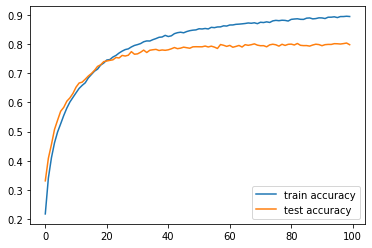

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
 
import os
os.chdir('/content/drive/My Drive')


fig = plt.figure()
loss_all, train_acc_all, test_acc_all
plt.plot(train_acc_all, label='train accuracy')
plt.plot(test_acc_all, label='test accuracy')
plt.legend(loc='lower right')

plt.savefig("picture/accuracy.png", dpi=100)
plt.show()
